In [4]:
import matplotlib.pyplot as plt
import numpy as np
from easyesn import ClassificationESN
from easyesn import OneHotEncoder
from easyesn.optimizers import GradientOptimizer
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
from sklearn.model_selection import train_test_split
import os
import math
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
def unencode(matrix):
    new_matrix = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        val = np.where(matrix[i]==1)[0]
        new_matrix[i] = classes[int(val)]
    return new_matrix

Using Numpy backend.


In [83]:
n_train = 2000
n_test = 2000
x_train = np.load('E:/xtrain.npy')[:n_train]
x_test = np.load('E:/xtest.npy')[:n_test]
y_train = np.load('E:/ytrain.npy')[:n_train]
y_test = np.load('E:/ytest.npy')[:n_test]

In [88]:
#esn = ClassificationESN(n_input=1, n_classes=len(y[0]), n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr")

esn = ClassificationESN(n_input=3, n_classes=len(y_train[0]),
                        n_reservoir=500,
                        regressionParameters=[1e-6],
                        spectralRadius=0.95, noiseLevel=0.00121,
                        inputScaling=None,
                        leakingRate=1,
                        reservoirDensity=0.2,
                        randomSeed=42,
                        weightGeneration='naive',
                        bias=1.0,
                        outputBias=1.0,
                        outputInputScaling=1.0,
                        inputDensity=0.2,
                        solver='pinv')
esn.fit(x_train, y_train, verbose=1)

100% (2000 of 2000) |####################| Elapsed Time: 0:01:00 Time:  0:01:00


0.376801339724515

100% (2000 of 2000) |####################| Elapsed Time: 0:00:59 Time:  0:00:59


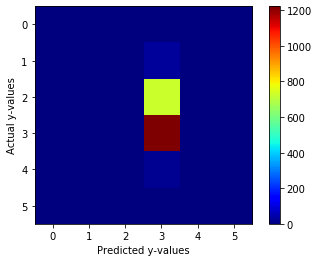

In [89]:
y_test_pred = esn.predict(x_train, transientTime=100, verbose=1)

classes = [0,1,2,3,4,5]
cm = confusion_matrix(unencode(y_train),unencode(y_test_pred),labels=classes)
plt.imshow(cm,cmap='jet')
plt.xlabel('Predicted y-values')
plt.ylabel('Actual y-values')
plt.colorbar()
plt.show()

In [86]:
import sys
inputLength = 760
n = len(os.listdir('E:/sector_lightcurves/'))

mags =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['GMAG'],header=0,squeeze=True).to_numpy()
magnesiums =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_MgII'],header=0,squeeze=True)
carbons =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_CIV'],header=0,squeeze=True)
masses = np.zeros(n)
for i in range(len(masses)):
    mag = magnesiums[i]
    car = carbons[i]
    if not math.isnan(mag) and not math.isnan(car):
        mass = 0.5*(mag+car)
    elif not math.isnan(mag):
        mass = mag
    elif not math.isnan(car):
        mass = car
    masses[i] = mass

mags = mags/np.max(mags)
y = np.zeros((n,6))
for i in range(len(masses)):
    if masses[i] < 8.5:
        y[i,0] = 1
    elif masses[i] < 8.75:
        y[i,1] = 1
    elif masses[i] < 9:
        y[i,2] = 1
    elif masses[i] < 9.25:
        y[i,3] = 1
    elif masses[i] < 9.5:
        y[i,4] = 1
    else:
        y[i,5] = 1

x = []
for file in os.listdir('E:/sector_lightcurves/')[:n]:
    row = int(file.split('-')[0])
    with open('E:/sector_lightcurves/'+file,'rb') as rfile:
        lc = pickle.load(rfile)
    lc = lc.remove_nans().remove_outliers(sigma=25)
    #cut_std = np.std(lc.remove_outliers(sigma=3).flux[:inputLength])
    cut_std = np.std(lc.flux[:inputLength])
    flux = lc.flux[:inputLength]/cut_std
    x.append(np.vstack((flux,mags[row]*np.ones(inputLength))).transpose())
x = np.array(x)

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [89]:
#alternative that doens't add another variable like mag
inputLength = 760
n = len(os.listdir('E:/sector_lightcurves/'))

magnesiums =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_MgII'],header=0,squeeze=True)
carbons =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_CIV'],header=0,squeeze=True)
masses = np.zeros(n)
for i in range(len(masses)):
    mag = magnesiums[i]
    car = carbons[i]
    if not math.isnan(mag) and not math.isnan(car):
        mass = 0.5*(mag+car)
    elif not math.isnan(mag):
        mass = mag
    elif not math.isnan(car):
        mass = car
    masses[i] = mass

mags = mags/np.max(mags)
y = np.zeros((n,6))
for i in range(len(masses)):
    if masses[i] < 8.5:
        y[i,0] = 1
    elif masses[i] < 8.75:
        y[i,1] = 1
    elif masses[i] < 9:
        y[i,2] = 1
    elif masses[i] < 9.25:
        y[i,3] = 1
    elif masses[i] < 9.5:
        y[i,4] = 1
    else:
        y[i,5] = 1

x = []
for file in os.listdir('E:/sector_lightcurves/')[:n]:
    row = int(file.split('-')[0])
    with open('E:/sector_lightcurves/'+file,'rb') as rfile:
        lc = pickle.load(rfile)
    lc = lc.remove_nans().remove_outliers(sigma=25)
    #cut_std = np.std(lc.remove_outliers(sigma=3).flux[:inputLength])
    cut_std = np.std(lc.flux[:inputLength])
    flux = lc.flux[:inputLength]/cut_std
    flux = np.array([np.array([flux[i]]) for i in range(len(flux))])
    x.append(flux)
x = np.array(x)

np.save('x_magless.npy',x)
np.save('y_magless.npy',y)

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data = np.random.uniform(3,2,(15,2))
print(data)
ss.fit_transform(data)

[[2.38544027 2.02439423]
 [2.91856997 2.87101523]
 [2.52816535 2.84213482]
 [2.86960241 2.90892078]
 [2.42733123 2.34374843]
 [2.10584282 2.66276945]
 [2.6516806  2.78581572]
 [2.0128003  2.59520533]
 [2.46011843 2.04024334]
 [2.05692964 2.4210092 ]
 [2.51029296 2.35402675]
 [2.62051666 2.7555925 ]
 [2.72198995 2.52081573]
 [2.02470773 2.33096586]
 [2.41247622 2.51063658]]


array([[-0.21797989, -1.86405661],
       [ 1.66681611,  1.25014641],
       [ 0.28660212,  1.14391297],
       [ 1.49369901,  1.38957784],
       [-0.06988102, -0.68934703],
       [-1.20645261,  0.48413702],
       [ 0.72327082,  0.93674933],
       [-1.53538977,  0.23560976],
       [ 0.04603295, -1.80575741],
       [-1.37937742, -0.40515171],
       [ 0.2234171 , -0.65153932],
       [ 0.61309563,  0.82557648],
       [ 0.97183844, -0.03802427],
       [-1.49329291, -0.73636631],
       [-0.12239854, -0.07546716]])

In [87]:
np.save('x_standardized.npy',x)
np.save('y_standardized.npy',y)

In [30]:
import os
#alternative that regresses
inputLength = 760
n = len(os.listdir('E:/sector_lightcurves/'))

magnesiums =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_MgII'],header=0,squeeze=True)
carbons =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_CIV'],header=0,squeeze=True)
masses = np.zeros(n)
for i in range(len(masses)):
    mag = magnesiums[i]
    car = carbons[i]
    if not math.isnan(mag) and not math.isnan(car):
        mass = 0.5*(mag+car)
    elif not math.isnan(mag):
        mass = mag
    elif not math.isnan(car):
        mass = car
    masses[i] = np.array([mass])

y = (masses-np.mean(masses))/np.std(masses)


print(y.shape)

x = []
for file in os.listdir('E:/sector_lightcurves/')[:n]:
    row = int(file.split('-')[0])
    with open('E:/sector_lightcurves/'+file,'rb') as rfile:
        lc = pickle.load(rfile)
    lc = lc.remove_nans().remove_outliers(sigma=25)
    #cut_std = np.std(lc.remove_outliers(sigma=3).flux[:inputLength])
    cut_std = np.std(lc.flux[:inputLength])
    flux = lc.flux[:inputLength]/cut_std
    flux = np.array([np.array([flux[i]]) for i in range(len(flux))])
    x.append(flux)
x = np.array(x)

np.save('E:/x_r.npy',x)
np.save('E:/y_r.npy',y)

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

(18955,)


In [34]:
np.min(y)

-4.726224090277038

In [16]:
x.shape

(18955, 760, 2)

In [42]:
file = '1-1lc.pickle'
print(file.split('lc')[0].split('-')[1])

1
